In [ ]:
#@title Installing and importing dependencies

#@markdown Run this cell if you plan to run the rest of cells with code.

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My Drive/DLProjects/JTM

!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.manifold import TSNE
import pretty_midi
from scipy.io import wavfile
import IPython.display as ipd

# Jaka to Melodia (JTM)

In our team we had people wishing to explore self-supervised learning techniques, as well as people interested from long before on applying machine learning to music. Our project, ***Jaka to Melodia*** (*What's the melody*) was the solution to satisfy us all.

Aside of the cool-factor of working with music, we considered it an interesting use-case for deep self-supervised learning as in [Humphrey et al. (2012)](http://yann.lecun.org/exdb/publis/pdf/humphrey-jiis-13.pdf), Humphrey, Bello, and LeCun stated: 

<center><i>“Deep architectures often require a large amount of labeled data for supervised training, a luxury music informatics has never really enjoyed. Given the proven success of supervised methods, MIR </i>(music information retrieval) <i> would likely benefit a good deal from a concentrated effort in the curation of sharable data in a sustainable manner”. </i> </center>

But, rather than spending resources and long and tedious hours on handcrafting huge labeled data sets for music, why not leverage the power of self-supervised learning to put to good use the massive amounts of unlabeled music data we have accumulated through centuries of human artistic production?.

Our goal was then to use self-supervised algorithms to train a deep learning model to extract useful latent variables from unlabeled raw music audio data. The usefulness of such representation was assessed by using them later for some **downstream tasks** for which we had labels (E.g. classifying the instrument and/or note playing at a certain moment) hoping to get improved performance with less labeled data with respect to a fully supervised model.

As our self-supervised algorithm we chose ***Contrastive Predictive Coding (CPC)***, a self-supervised algorithm quite well-suited for sequential data as it is music, and which we found  interesting not just conceptually, but because it is related to ongoing research in our university.

In the next sections we describe the CPC algorithm, describe our experiments and present the obtained results and conclusions.

# Contrastive Predictive Coding (CPC)

Contrastive Predictive Coding ([van den Oord et al., 2019](https://arxiv.org/pdf/1807.03748.pdf)) is a self-supervised learning algorithm to extract useful representations from high-dimensional data. The main idea behind CPC is to learn representations that encode the underlying shared information between different parts of the input, for instance between a pixel and its neighbors in an image, or the past and future in a sequence.

Fig. 1 illustrates the architecture of the CPC model, which consists of:

* An encoder $g_{enc}$ that maps an observation $x_t \in \mathbb{R^d}$ at time (or position) $t$ to a latent representation $z_t = g_{enc}(x_t) \in \mathbb{R}^{p}$, with $p < d$.

* An auto-regressive model $g_{ar}$ that summarizes all $z_{\leq t}$ into a context latent representation $c_t = g_{ar}(z_{\leq t}) \in \mathbb{R}^{m}$.

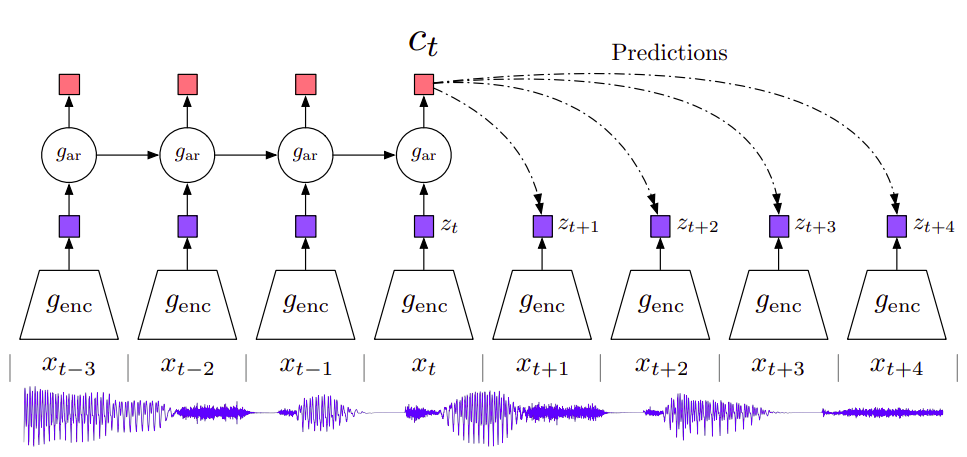

<center>Figure 1. Overview of Contrastive Predictive Coding</center>

Given a set $Z = \{z_1, \dots, z_N\}$ of $N$ random samples from the set of encoded observations containing one positive sample from $p(z_{t + k}|c_t)$ and $N - 1$ negative samples from the marginal distribution $p(z)$, the model is trained so as to minimize the loss function:

$$
\cal{L} = -\sum_{k=1}^K \mathbb{E}_{Z}\left[\frac{\exp(z_{t + k}^T W_k c_t)}{\sum_{x_j \in Z} \exp(z_j^T W_k c_t)} \right]
$$, where each $W_k \in \mathbb{R}^{p \times m}$ are also trainable parameters. 

This can be interpreted as $\mathcal{K}$ softmax classifiers between positive and negative samples in which the logits are the similarity (according to the dot product) between the predicted value of the encoded observation $k$ steps in the future $\tilde{z}_{t + k} = W_k c_t$, and the encoded observations in $Z$. As such, we are trying to maximize the correlation between $z_{t + k}$ and $c_t$, and therefore the usefulness of $c_t$ to predict the future.

By optimizing for the $c$ vectors to carry information about distant time steps in the future we are hoping to capture slowly changing latent variables, such as phonemes in speech, an object in an image, a topic in a text, or the key-stroke of a piano in a song.

<sub>*Note: the loss function described in the original paper uses a slightly different formulation, however this is the one we implemented. The authors proved the pretty cool fact that minimizing their loss function is equivalent to maximizing the mutual information between $x$ and $c$. We refer the reader to [van den Oord et al.(2019)](https://arxiv.org/pdf/1807.03748.pdf)
 for further information.*<sub>

# Experiments and results

Our implementation of CPC for the MusicNet data set can be found in [our project repository](https://github.com/tiagoCuervo/JTM) and it is based on the [Facebook's implementation of CPC for speech](https://github.com/facebookresearch/CPC_audio). Our modifications consisted mostly in adapting the input pipeline to our dataset and downstream tasks and changes to the architecture of the neural networks. Below we describe the stages of our project, the experiments performed, and present our results.

## Data set

We used the MusicNet data set [(Thickstun et al., 2016)](https://arxiv.org/pdf/1611.09827.pdf), a collection of 330 freely-licensed classical music recordings, together with over 1 million annotated labels indicating the precise time of each note in every recording, the instrument that plays each note, and the note's position in the metrical structure of the composition, as well as some aditional meta data, such as the ensemble of instruments used for the composition, and the composer.

We chose MusicNet as its size was reasonable for our compute resources and purposes (~11 GB, 34 hours of music), it provided us with labels useful for multiple downstream tasks, and we thought that focusing on a single genre would make learning easier for the neural net as the data it would be trying to model was less diverse while still being reasonably complex (11 instruments arranged in 21 different ensembles).

As MusicNet had a sampling frequency of 44.1 kHz, which was hard to deal with with our compute resources, we downsampled it to 16 kHz. **Each observation ($x_t$) consisted then of 20480 samples** (1.28 seconds of audio). 



## CPC training

We performed several initial experiments to validate our implementation of CPC. At first, we were using the architecture described in [van den Oord et al.(2019)](https://arxiv.org/pdf/1807.03748.pdf), that is, a regular 1D convolutional network as $g_{enc}$ and a GRU network as $g_{ar}$, but we found our first obstacle in the $g_{ar}$ component. In about half of our experiments the model behaved as shown below:

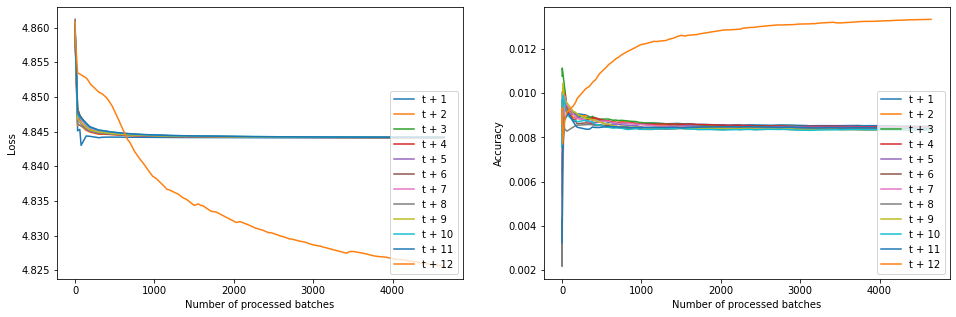

In [ ]:
#@title
plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('cpc_samesequence_gru_conv_train_losses.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend(loc='lower right')
plt.xlabel(r"Number of processed batches")
plt.ylabel(r"Loss")
plt.subplot(122)
f = open('cpc_samesequence_gru_conv_train_accuracies.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend(loc='lower right')
plt.xlabel(r"Number of processed batches")
plt.ylabel(r"Accuracy")
plt.show()

The plots show the cross-entropy loss (left) and accuracy (right) of our softmax classifier for positive/negative samples for $k \in \{1, \dots, 12\}$.

After inspecting the gradients we realized that the ones of the convolutional layers were practically negligible. The GRU did not seem to be able to learn to keep anything useful in its state to predict the next time steps, and no informative gradients were propagated to the encoder. Quite oddly, the loss for the time step further ahead in time (t + 12), which should be the hardest to predict, seemed to be the only one decreasing. We still need to figure out why this was the case. This could probably have been fixed with some careful initialization of the GRU (considering the spectral radius), but at the moment we decided not to put too much thought into it, and proceeded to try with other architectures. 

We changed the vanilla convolutional encoder for a SincNet [(Ravanelli, Bengio, 2019)](https://arxiv.org/pdf/1808.00158.pdf), and then everything started working properly. This makes sense, as the GRU depends on the convolutional encoder to provide it a useful representation of the sequence to predict future time steps. If the convolutional encoder does not keep important information from the input, then the GRU cannot predict anything useful, and then the outputs are no better than random guesses and the gradients are not informative. Since SincNet provides some useful priors it helped $g_{enc}$ to quickly discover a good encoding, and then the GRU produced proper predictions allowing it to get informative gradients. We also changed the GRU for an autoregressive encoder, as it led to faster convergence and less compute time. **With our final architecture we obtained a sequence of 128 latent vectors (that is downsampling factor of $20480 / 128 = 160$) of dimension $p=512$ and as such also a sequence of 128 latent context vectors $c_t$ of dimension $m=512$**.

After having settled on the architecture of our neural nets, we trained several CPC models using diferent strategies to draw the negative samples for the loss, as this can affect the information that the model learns to capture in its representations. As an example taken from the CPC paper for the case of speech: if we wish to learn representations useful for phoneme classification we should take the negative samples from the same speaker, so as to not allow the model to learn to use the identity of the speaker to discriminate between positive and negative samples. We tried four negative sampling strategies: 

* *From the same ensemble* (set of instruments taking part in the piece): with the objective of checking if the neural net could use the type of instrument to discriminate, therefore maybe discarding the precise information of the notes.
* *From the same composer*: with the objective of checking if the neural net could use the composer to discriminate, although this was far fetched as the style of the composer has likely long temporal dependencies (ie. only identifiable with very large and computationally expensive time windows of multiple seconds).
* *From the whole data set*: this should have been the less demanding, as the model could use all of the previously mentioned hints to discriminate.
* *From the same piece*: this should have been the most demanding, likely forcing the model to pick up precise information about the notes, and instruments being played.

Below we show the results of training the CPC model for each of these strategies, once again, in terms of the cross-entropy loss (left) and accuracy (right) of the softmax classifier for positive/negative samples for $k \in \{1, \dots, 12\}$.


1. With negative samples obtained from the same track (same musical piece)

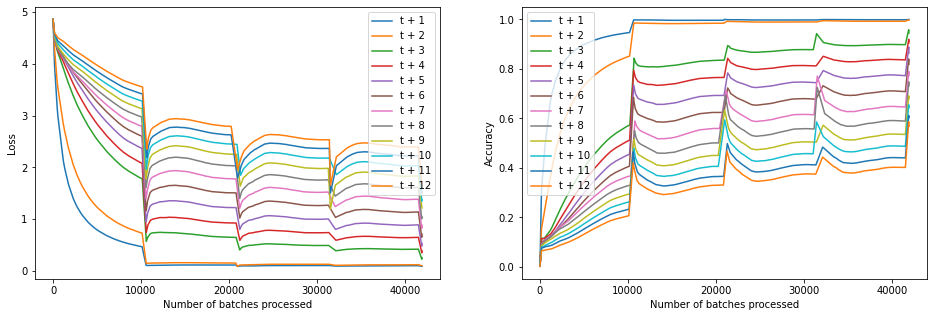

In [ ]:
#@title
plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('cpc_samesequence_sinc_trans_train_losses.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Loss")
plt.subplot(122)
f = open('cpc_samesequence_sinc_trans_train_accuracies.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Accuracy")
plt.show()

2. With negative samples obtained from the same musical ensemble (i.e. all samples from pieces corresponding to a string quartet):

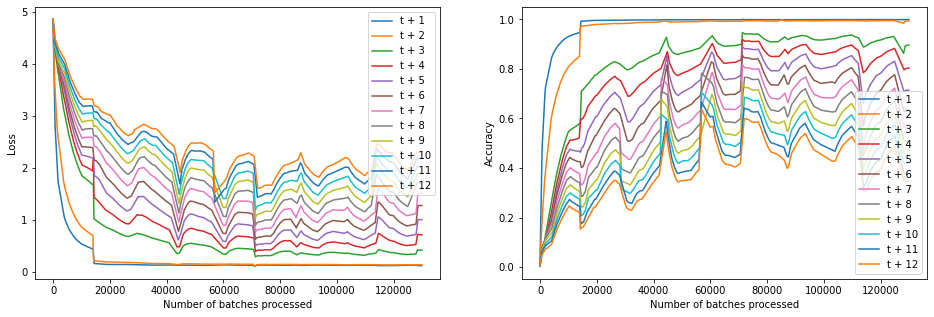

In [ ]:
#@title
plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('cpc_sameensemble_sinc_trans_train_losses.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Loss")
plt.subplot(122)
f = open('cpc_sameensemble_sinc_trans_train_accuracies.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Accuracy")
plt.show()

3. With negative samples obtained from the same composer:

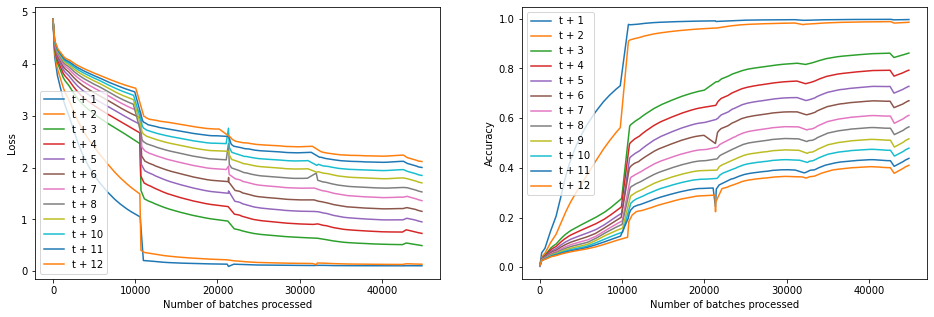

In [ ]:
#@title
plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('cpc_samecomposer_sinc_trans_train_losses.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Loss")
plt.subplot(122)
f = open('cpc_samecomposer_sinc_trans_train_accuracies.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Accuracy")
plt.show()

4. With negative samples sampled uniformly from the whole data set:

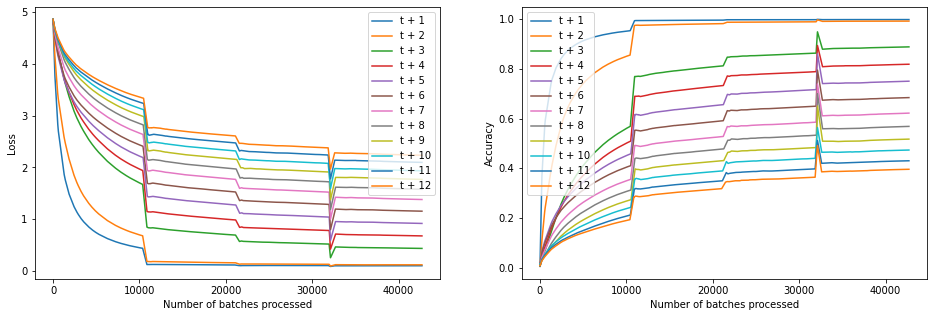

In [ ]:
#@title
plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('cpc_uniform_sinc_trans_train_losses.json')
data = json.load(f)
plt.subplot
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Loss")
plt.subplot(122)
f = open('cpc_uniform_sinc_trans_train_accuracies.json')
data = json.load(f)
for i in range(12):
    for dat in data:
        if dat["name"].split('_')[-1] == str(i):
            plt.plot(dat['x'], dat['y'], label=r"t + %d" % (i + 1))
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Accuracy")
plt.show()

We can see that in all cases there seems to be convergence, and, as expected, the ability of the model to discriminate positive from negative samples decreases when predicting further into the future, that is, the present is more influenced by recent events than by the distant past.

Most of the curves seem rather similar regardless of the negative sampling strategy, with the exception of the sampling by same ensemble. This is probably because in this experiment we were forced to use a different setup for the data loader, and is likely that the data was not properly shuffled. 

It should also be noted that the sudden jumps in the curves are because these curves correspond to a running mean per epoch of the loss/accuracy per batch, therefore at the beginning of every epoch (small denominator in the average calculation) a spike will happen.

## Downstream tasks

We applied our learned CPC encodings to two tasks: ensemble classification and automatic music transcription. Below we describe them in detail.

### Ensemble classification

We trained several models for the downstream task of musical ensemble classification. This is not at all a trivial task, as the model has to tell from just 1.28 seconds of audio what kind of musical ensemble (arranges of instruments) is playing.

We trained models using a random encoder, the CPC encoders obtained using negative samples from the same sequence and uniform negative sampling, and a fully supervised model in which the encoder is also trained. To apply the random encoder to the downstream tasks we used a linear classifier that received as input the result of passing the encodings through an average pooling layer (with the objective of reducing the dimension) with kernel size 4 and stride 4. For the CPC encoders we used both, a linear classifier, and a small neural network with a single hidden layer of 100 units and ReLU activation. 

The plots below summarize the obtained results in terms of the cross-entropy loss, the classification accuracy, and the confusion matrices:

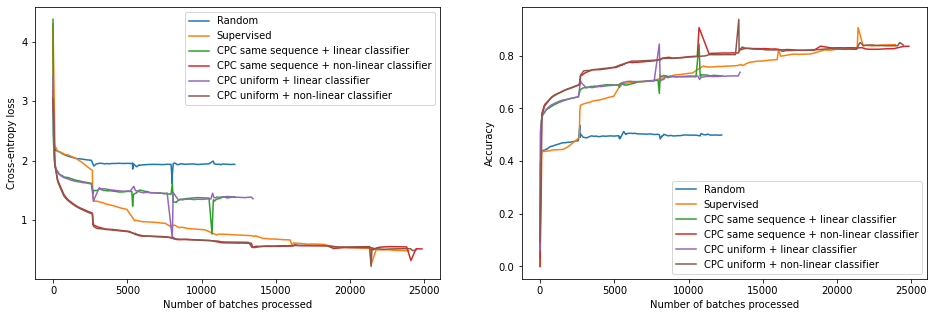

In [ ]:
#@title

labels = ['Accompanied Cello', 'Accompanied Clarinet', 'Accompanied Violin', 
          'Clarinet Quintet', 'Clarinet-Cello-Piano Trio', 'Horn Piano Trio', 
          'Pairs Clarinet-Horn-Bassoon', 'Piano Quartet', 'Piano Quintet', 'Piano Trio', 
          'Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin', 'String Quartet', 
          'String Sextet', 'Viola Quintet', 'Violin and Harpsichord', 'Wind Octet', 
          'Wind Quintet', 'Wind and Strings Octet']

plt.figure(figsize=(16, 5))
plt.subplot(121)
f = open('downstream_samesequence_ensemble_random_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"Random")
f = open('downstream_samesequence_ensemble_supervised_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"Supervised")
f = open('downstream_samesequence_ensemble_cpclinear_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC same sequence + linear classifier")
f = open('downstream_samesequence_ensemble_cpcnonlinear_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC same sequence + non-linear classifier")
f = open('downstream_uniform_ensemble_cpclinear_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC uniform + linear classifier")
f = open('downstream_uniform_ensemble_cpcnonlinear_losses.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC uniform + non-linear classifier")
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Cross-entropy loss")
plt.subplot(122)
f = open('downstream_samesequence_ensemble_random_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"Random")
f = open('downstream_samesequence_ensemble_supervised_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"Supervised")
f = open('downstream_samesequence_ensemble_cpclinear_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC same sequence + linear classifier")
f = open('downstream_samesequence_ensemble_cpcnonlinear_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC same sequence + non-linear classifier")
f = open('downstream_uniform_ensemble_cpclinear_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC uniform + linear classifier")
f = open('downstream_uniform_ensemble_cpcnonlinear_accuracies.json')
data = json.load(f)
plt.plot(data[0]['x'], data[0]['y'], label=r"CPC uniform + non-linear classifier")
plt.legend()
plt.xlabel(r"Number of batches processed")
plt.ylabel(r"Accuracy")
plt.show()

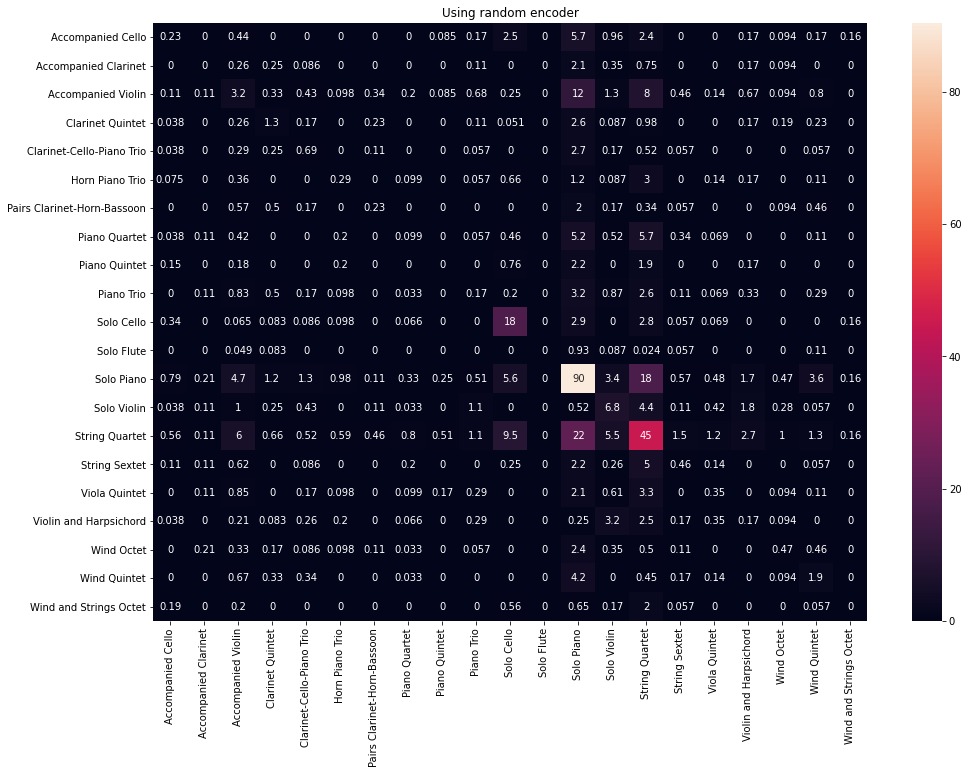

In [ ]:
#@title
f = open('downstream_samesequence_ensemble_random_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using random encoder")
plt.show()

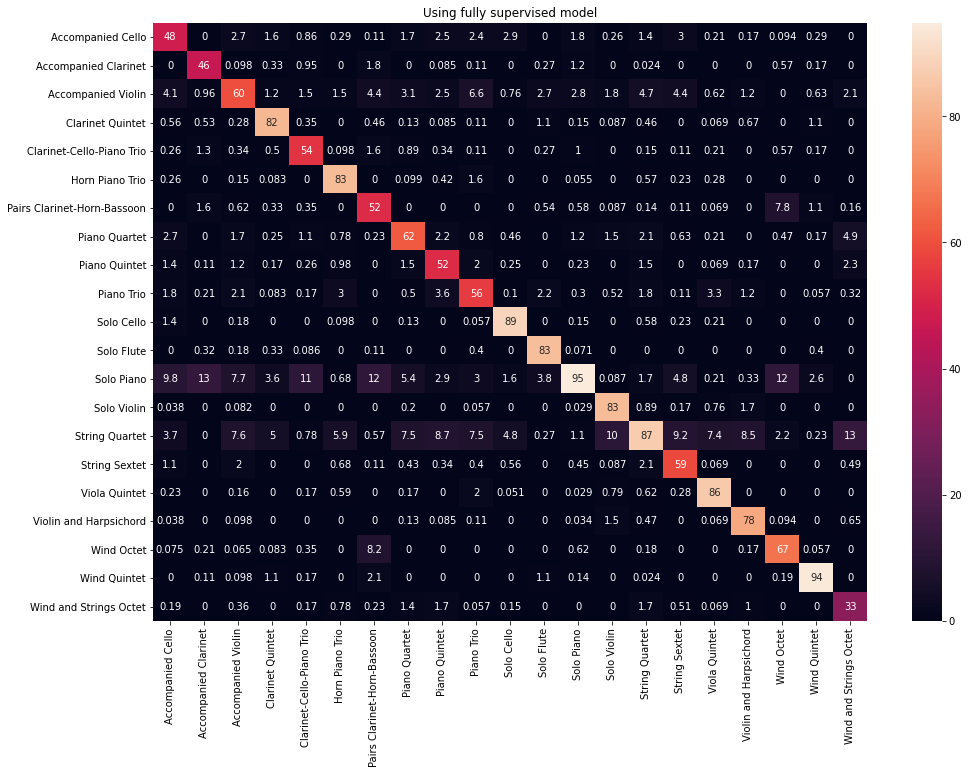

In [ ]:
#@title
f = open('downstream_samesequence_ensemble_supervised_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using fully supervised model")
plt.show()

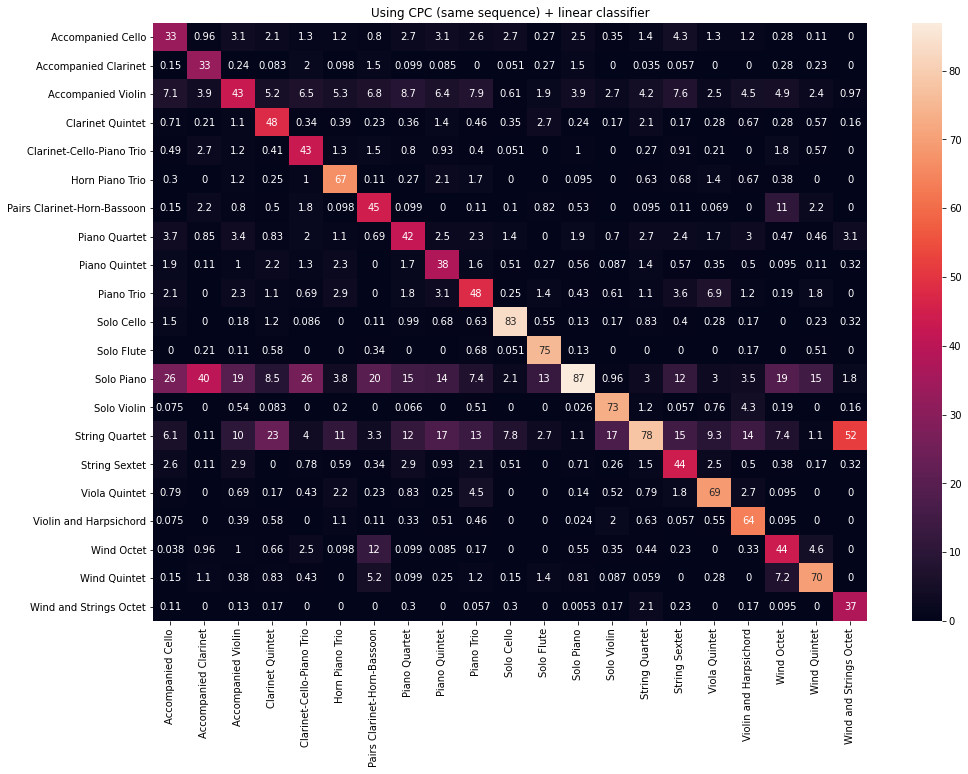

In [ ]:
#@title
f = open('downstream_samesequence_ensemble_cpclinear_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using CPC (same sequence) + linear classifier")
plt.show()

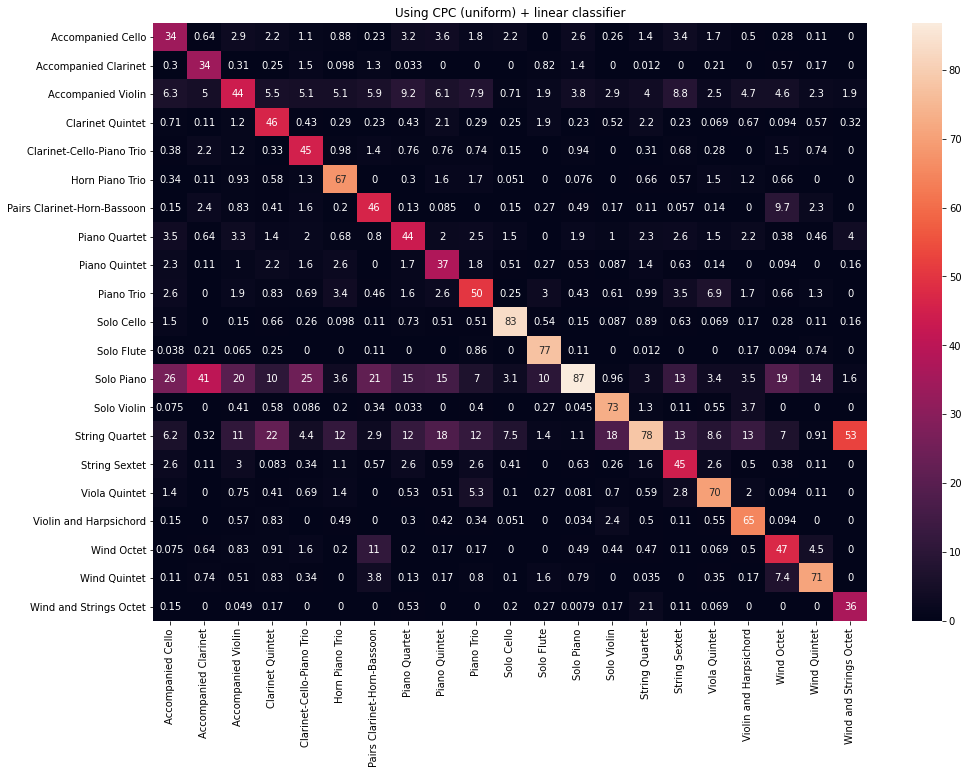

In [ ]:
#@title
f = open('downstream_uniform_ensemble_cpclinear_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using CPC (uniform) + linear classifier")
plt.show()

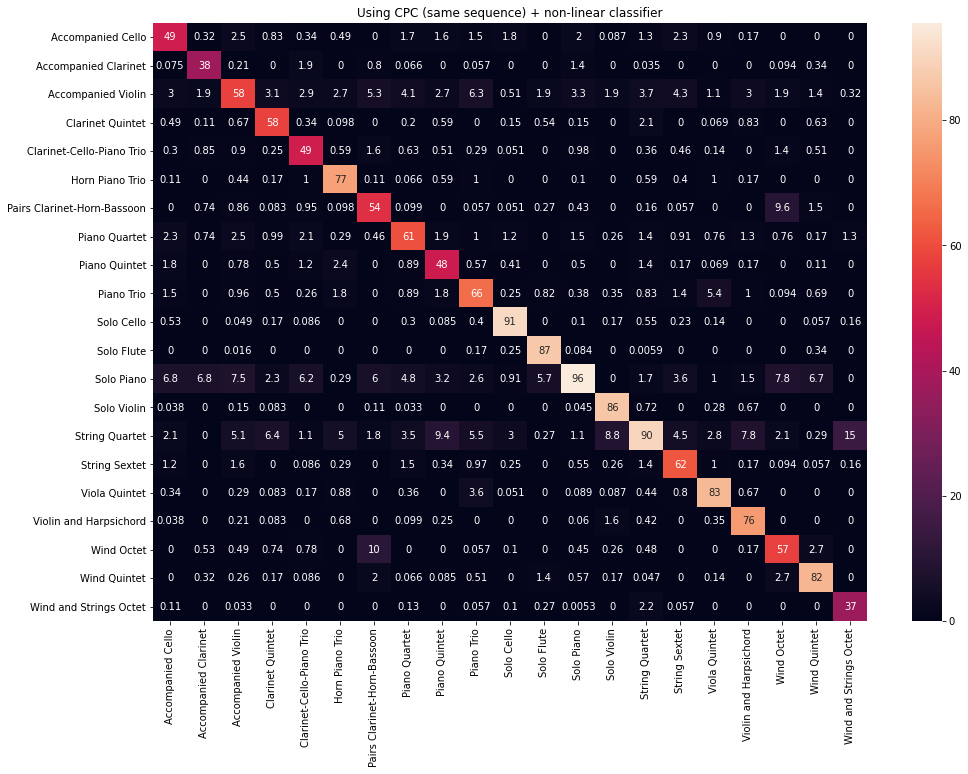

In [ ]:
#@title
f = open('downstream_samesequence_ensemble_cpcnonlinear_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using CPC (same sequence) + non-linear classifier")
plt.show()

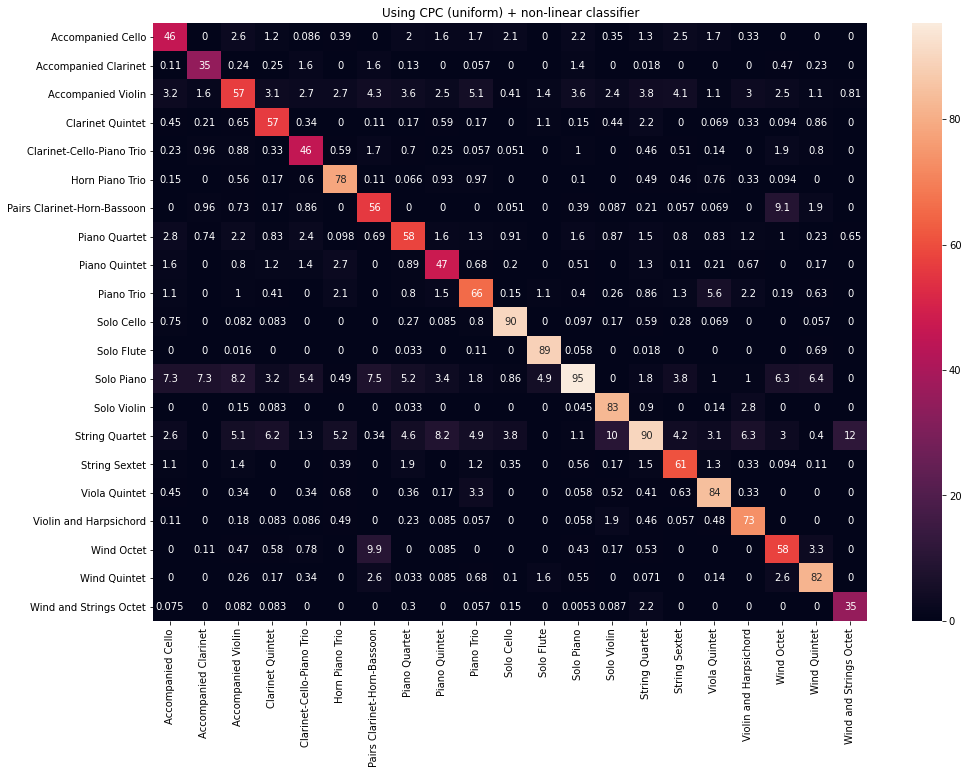

In [ ]:
#@title
f = open('downstream_uniform_ensemble_cpcnonlinear_confussion.json')
data = json.load(f)
confusionMatrix = np.array(data['matrix'])
confusionMatrix = (confusionMatrix / np.sum(confusionMatrix, axis=1)) * 100
df_cm = pd.DataFrame(confusionMatrix, index = labels, columns = labels)
plt.figure(figsize = (16,11))
sns.heatmap(df_cm, annot=True)
plt.title("Using CPC (uniform) + non-linear classifier")
plt.show()

It can be seen that:

* The random encoder is not able to extract useful features. From the confusion matrix we see that it only learns to favor the majority classes (the data set for ensemble classification is imbalanced).

* The CPC encoders do manage to extract useful features. The CPC encoder with linear classifier achieves a higher accuracy than the model using the random encoder, and in the confusion matrix is evidenced that it does learn to tell apart the different classes.

* The fully supervised model achieves a higher classification performance than the one with CPC encoder and linear classifier, as it can be evidenced from the accuracy curve and the confusion matrices. However, it converges slower than the models using random and CPC encoders.

* The model with CPC encoder and non-linear classifier performs as well as the fully supervised model in terms of classification performance, but converges much faster. 

* The fact that the CPC encoder with a non linear classifier outperforms the one with a linear classifier indicates that the features extracted by CPC do not make the classes linearly separable. 

* Both negative sampling strategies, sampling from the same sequence and uniformly, give almost identical results.

* Interestingly, by looking at the confusion matrices of all the models it can be seen that the majority classes are the ones more frequently misclassified. These classes, solo piano and string quartet, consist of instruments that are also frequently present on other ensembles, and therefore makes sense that won't be easily told apart from the rest. Considering larger sequences (more than the 1.28 seconds used here) would likely result in better classification performance.

#### Data efficiency comparison

As stated before, we wanted to use self-supervised learning to get improved performance with less labeled data with respect to a fully supervised model. We already saw in the previous plots that using CPC as pre-training considerably increases the speed of convergence of the model with respect to a fully supervised one, but, what about the amount of labels needed?. To answer this question we trained once again our CPC-based model (using uniform negative sampling) and fully supervised model on the ensemble classification task using smaller fractions of the labeled data. The plot below shows the obtained results in terms of the best obtained accuracy.

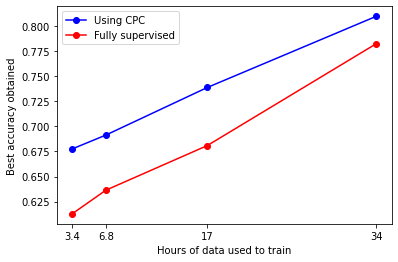

In [ ]:
#@title

f = open('downstream_uniform_ensemble_cpcnonlinear_accuracies_val.json')
dataCPCAll = json.load(f)
f = open('downstream_uniform_ensemble_cpcnonlinear_accuracies_half.json')
dataCPCHalf = json.load(f)
f = open('downstream_uniform_ensemble_cpcnonlinear_accuracies_onefifth.json')
dataCPCFifth = json.load(f)
f = open('downstream_uniform_ensemble_cpcnonlinear_accuracies_onetenth.json')
dataCPCTenth = json.load(f)

f = open('downstream_samesequence_ensemble_supervised_accuracies_val.json')
dataSupervisedAll = json.load(f)
f = open('downstream_samesequence_ensemble_supervised_accuracies_half.json')
dataSupervisedHalf = json.load(f)
f = open('downstream_samesequence_ensemble_supervised_accuracies_onefifth.json')
dataSupervisedFifth = json.load(f)
f = open('downstream_samesequence_ensemble_supervised_accuracies_onetenth.json')
dataSupervisedTenth = json.load(f)

x = [34/10, 34/5, 17, 34]
yCPC = [max(dataCPCTenth[0]['y']), max(dataCPCFifth[0]['y']), max(dataCPCHalf[0]['y']), max(dataCPCAll[0]['y'])]
ySupervised = [max(dataSupervisedTenth[0]['y']), max(dataSupervisedFifth[0]['y']), max(dataSupervisedHalf[0]['y']), max(dataSupervisedAll[0]['y'])]

# plt.figure(figsize=(16, 5))
plt.plot(x, yCPC, '-bo', label='Using CPC')
plt.plot(x, ySupervised, '-ro', label='Fully supervised')
plt.xticks(x, ['3.4', '6.8', '17', '34'])
# plt.yscale('log')
plt.xlabel('Hours of data used to train')
plt.ylabel('Best accuracy obtained')
plt.legend()
plt.show()

We can see that the model using the CPC encoder consistently outperforms the fully supervised model, although the difference seems to shorten for larger data sets, showcasing the usefulness of self-supervised learning in small-data cases. 

It is also worth to mention that even for the full 34 hours of audio, the CPC model outperforms the supervised one, indicating that to get a similar performance the supervised model would require larger data sets than the ones currently available. 

### Automatic music transcription

The transcription task was quite a challenge for a multiple of reasons:

- Preparing the suitable labels that would work with our dataloader has been probably the task we have probably spent on most of our project time working 

- Apart from preparing suitable input pipelines, another issue we faced has been the size of the transcripted (labeled) window which would have been used for the downstream classification. Initially, we have considered the time window spanned by the same amount of time as the encoded latent vectors (ie. 10ms) which would give us a one-to-one correspondence of latent input to the classification network and the labels. However, our experiments showed that this does not give satisfactory results and we have attempted at aggregating the encoded vectors through average pooling in order to consider wider windows. 

- Another issue we thought we were facing has been the significant imbalance of classes (ie. notes being played and not as indicated by ones and zeros respectively): given that there is a limited number of notes a human can possible play in a short time window and rather short length of those we have considered, the labels were mostly sparse binary tensors. Therefore, in our first experiments we were trying to give the positive classes increased weights. This however turned out unnecessary later as evidenced by numerical results.

In our analysis we have focused on the transcription of solo piano for a coule of reasons: for one, piano has been the most frequent instrument in our dataset. Secondly, we didn't want to rush into deep waters with a whole orchestra ensemble, instead we wanted to test whether we would get anything sensible from a simpler problem of just one instrument.

Similarly to the previous downstream classification, we have trained our models using a random encoder, the CPC encoder obtained using negative samples from uniform negative sampling, and a fully supervised model in which the encoder is also trained. As a classifier, we have used a small neural network with a single hidden layer of 100 units trained on top of the CPC architecture. The considered transcription windows have been equal to 80, 160, 320 and 640ms by passing the latent vectors through an average pooling layers with appropriate kernel sizes and strides. the learning curves obtained with each of them are depicted in the plots below:

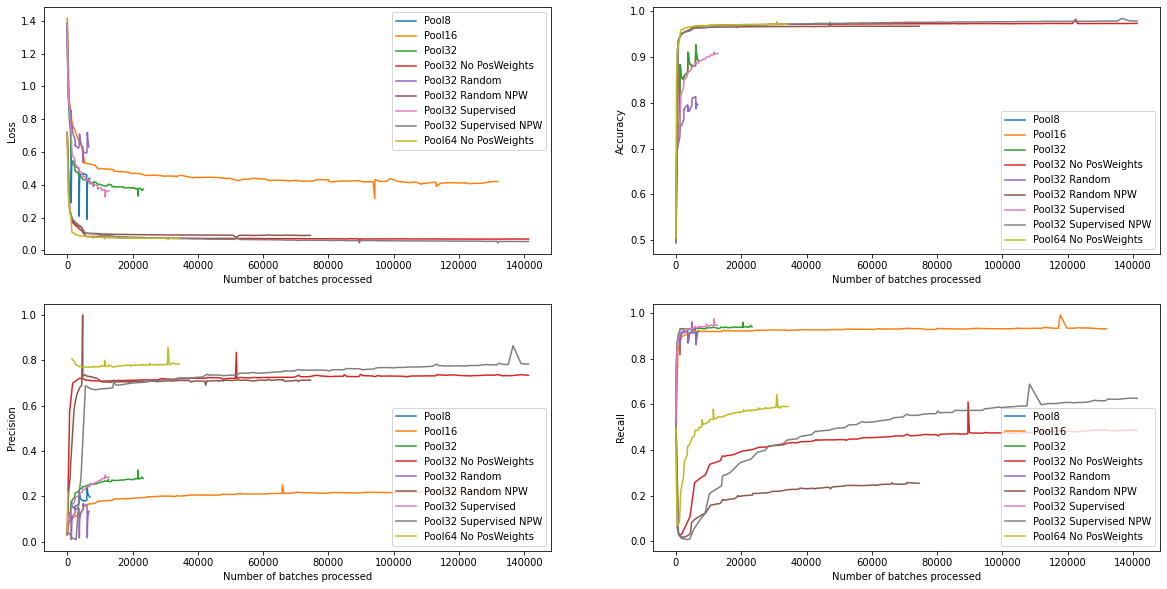

In [4]:
#@title
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

f = open('loss_pool8.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool8")
f = open('loss_pool16.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool16")
f = open('loss_pool32.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32")
f = open('loss_pool32noweights.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 No PosWeights")
f = open('loss_random.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random")
f = open('loss_random_nw.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random NPW")
f = open('loss_supervised.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised")
f = open('loss_supervised_nw.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised NPW")
f = open('loss_pool64noweights.json')
data = json.load(f)
axs[0, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool64 No PosWeights")
axs[0, 0].legend()
axs[0, 0].set_xlabel(r"Number of batches processed")
axs[0, 0].set_ylabel(r"Loss")


f = open('prec_pool8.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool8")
f = open('prec_pool16.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool16")
f = open('prec_pool32.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32")
f = open('prec_pool32noweights.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 No PosWeights")
f = open('prec_random.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random")
f = open('prec_random_nw.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random NPW")
f = open('prec_supervised.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised")
f = open('prec_supervised_nw.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised NPW")
f = open('prec_pool64noweights.json')
data = json.load(f)
axs[1, 0].plot(data[0]['x'], data[0]['y'], label=r"Pool64 No PosWeights")
axs[1, 0].legend()
axs[1, 0].set_xlabel(r"Number of batches processed")
axs[1, 0].set_ylabel(r"Precision")



f = open('acc_pool8.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool8")
f = open('acc_pool8.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool16")
f = open('acc_pool8.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32")
f = open('acc_pool32noweights.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 No PosWeights")
f = open('acc_random.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random")
f = open('acc_random_nw.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random NPW")
f = open('acc_supervised.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised")
f = open('acc_supervised_nw.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised NPW")
f = open('acc_pool64noweights.json')
data = json.load(f)
axs[0, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool64 No PosWeights")
axs[0, 1].legend()
axs[0, 1].set_xlabel(r"Number of batches processed")
axs[0, 1].set_ylabel(r"Accuracy")



f = open('rec_pool8.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool8")
f = open('rec_pool16.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool16")
f = open('rec_pool32.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32")
f = open('rec_pool32noweights.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 No PosWeights")
f = open('rec_random.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random")
f = open('rec_random_nw.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Random NPW")
f = open('rec_supervised.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised")
f = open('rec_supervised_nw.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool32 Supervised NPW")
f = open('rec_pool64noweights.json')
data = json.load(f)
axs[1, 1].plot(data[0]['x'], data[0]['y'], label=r"Pool64 No PosWeights")
axs[1, 1].legend()
axs[1, 1].set_xlabel(r"Number of batches processed")
axs[1, 1].set_ylabel(r"Recall")

plt.show()

Couple of remarks about the above plots:

- The CPC encoder has indeed been able to extract useful features which allow for automatic music transcription. Random encoder and a fully supervised models shows rather similar performance to that obtained with a CPC encoder, the former being very surprising. Similarly to the previous downstream task, we see that the supervised model takes longer time to converge.

- For the experiments with assigned positive weights, with increasing size of the labeled window, the precision was also increasing increased but was very poor overall (less than 30%), while recall and accuracy remained more or less constant and high. This is roughly in agreement with our intuition given that the labels are dominated by zeros (note not being played), while ones (notes being played) are the minority class. 

- Considering the plots of predicted transcrits, we noticed a very big number of false positives. When the positive classes were not upweighted, the precision almost quadrupled, but at the cost of lower recall. The predicted transcript plots showed that the model has been able to correctly predict the position of notes (sometmes not for their whole duration), and the audio files produced sounded rather nice with a clearly distinguishable melody line and surprisingly low level of cacophony.

- All models have been traiend with a simple network with a single hidden layer. It is possible that a different choice of the classifier could have improved our results and it would be very interesting to test this.

Below we present a sample transcription plot obtained from our best performing model, ie. transcription window of 640 ms:

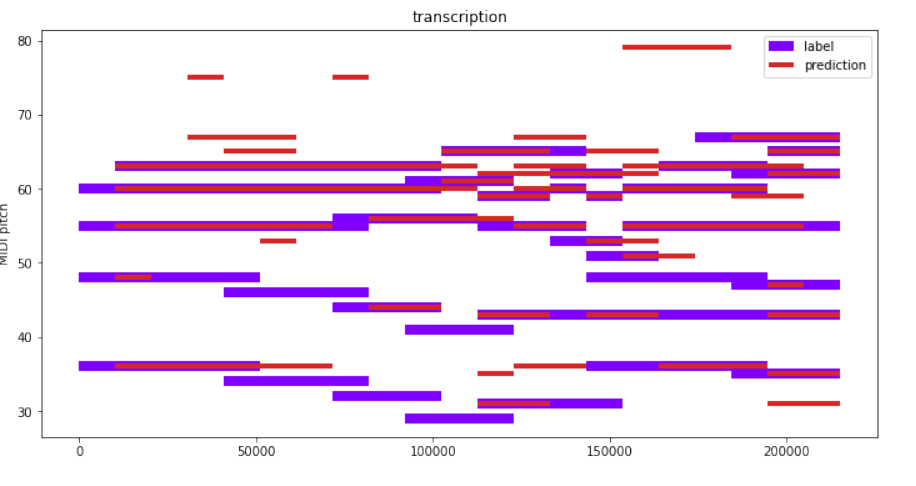
<center>25 of transcription</center>

Additionally, we provide audio samples of the true labels for the above music piece along with the predictions obtained from our best-performing model:

In [ ]:
#@title Label
ipd.Audio(f'audio_outputs/stereo_file-2350_label.wav')

In [ ]:
#@title Prediction
ipd.Audio(f'audio_outputs/stereo_file-2350_pred.wav')

We can hear that the main melody line is clearly distinguishable and matches the original one. Additionally, partially visible in the transcription plot above or evidenced by provided audio files, the majority of falsely identified notes are in harmony with the rest of predictions, which could suggest that information about musical scales or harmonical note progression has been preserved in the context vectors.

# Analysis of the features extracted by CPC

As a final step in our project we wanted to peek a bit into the black-box that was our CPC-encoder. The results on the downstream tasks already suggested that the encodings contained useful information to tell apart instruments and notes, but we wanted to get further evidence to support this conclusions. To do so, we first gathered a bunch of the encodings produced for different fragments of the data set, passed them thrugh an average pooling layer with kernel size 8 and stride 8, and tried to visualize them using t-SNE and to identify clusters according to the labels we had available for such fragments.



### Telling apart instruments

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


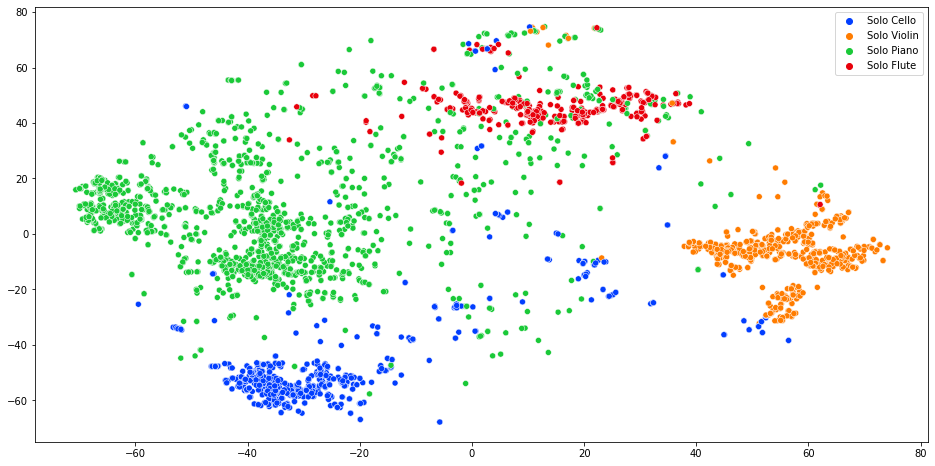

In [ ]:
#@markdown In the plot below we colored the t-SNE vectors according to the instrument to which they correspond. First, we show the ones corresponding to solo instruments. We can see well differetiated clusters for each instrument. We also notice that piano, which is the most common accompainment in other ensembles, is the one with the most spread on the embedded space.

with open(f'cVectors_ensemble.pickle', 'rb') as handle:
    cFeatures, trackIndices = pickle.load(handle)

with open(f'cFeaturesTsne_ensemble.pickle', 'rb') as handle:
    cFeaturesTsne = pickle.load(handle)

metadata = pd.read_csv(f'data/musicnet_metadata_train_ensemble_cpc_analysis.csv', index_col='id')
labelsPlotEnsemble = []
for trackIdx in trackIndices:
    labelsPlotEnsemble.append(np.unique(metadata.loc[trackIdx]['ensemble'])[0])

selectedEnsembles = ['Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin']
filteredLabelsPlot = np.array(labelsPlotEnsemble)[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0]]
filteredcFeaturesTsne = cFeaturesTsne[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0], :]

plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=len(np.unique(labelsPlotEnsemble)))
sns.scatterplot(filteredcFeaturesTsne[:,0], filteredcFeaturesTsne[:,1], hue=filteredLabelsPlot, legend='full', 
                palette=sns.color_palette("bright", len(selectedEnsembles)))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


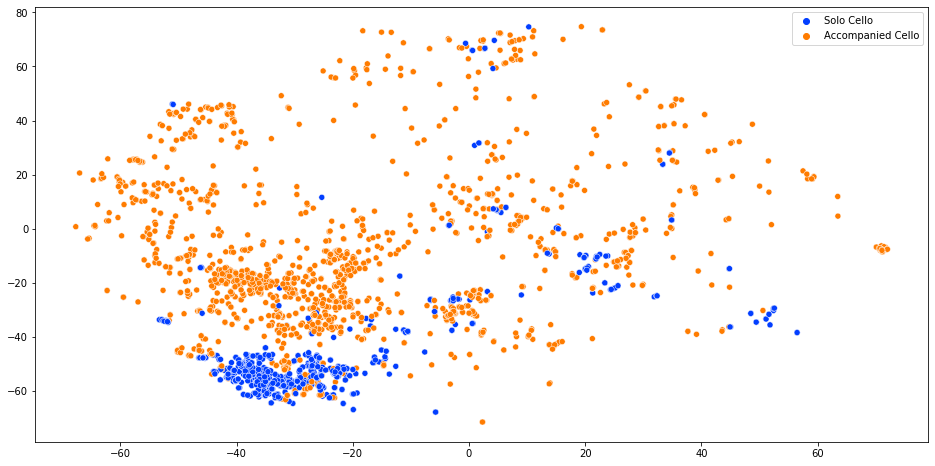

In [ ]:
#@markdown Now we visuallize the samples related to cello. Its closeness in the embedded space suggest that the model can also tell in pieces with accompainment what is the main instrument.

selectedEnsembles = ['Solo Cello', 'Accompanied Cello']
filteredLabelsPlot = np.array(labelsPlotEnsemble)[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0]]
filteredcFeaturesTsne = cFeaturesTsne[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0], :]

plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=len(np.unique(labelsPlotEnsemble)))
sns.scatterplot(filteredcFeaturesTsne[:,0], filteredcFeaturesTsne[:,1], hue=filteredLabelsPlot, legend='full', 
                palette=sns.color_palette("bright", len(selectedEnsembles)))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


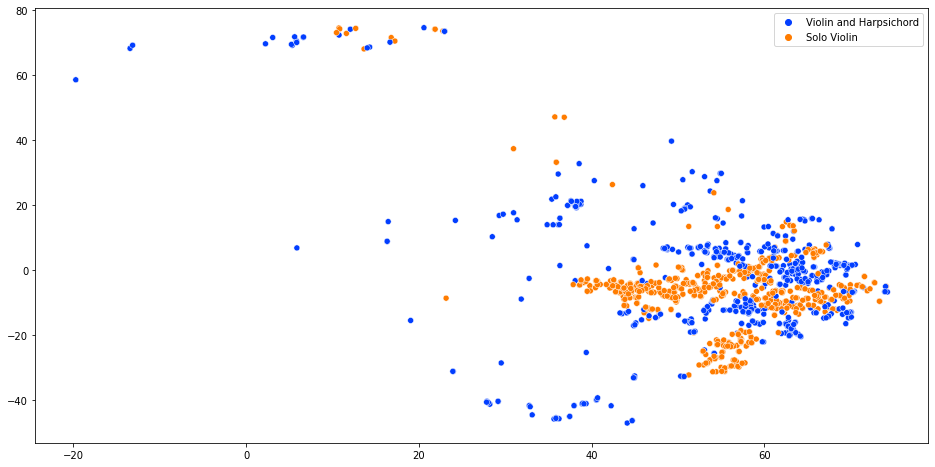

In [ ]:
#@markdown As with cello, the model tends to group the samples related to violin.

selectedEnsembles = ['Solo Violin', 'Violin and Harpsichord']
filteredLabelsPlot = np.array(labelsPlotEnsemble)[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0]]
filteredcFeaturesTsne = cFeaturesTsne[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0], :]

plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=len(np.unique(labelsPlotEnsemble)))
sns.scatterplot(filteredcFeaturesTsne[:,0], filteredcFeaturesTsne[:,1], hue=filteredLabelsPlot, legend='full', 
                palette=sns.color_palette("bright", len(selectedEnsembles)))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


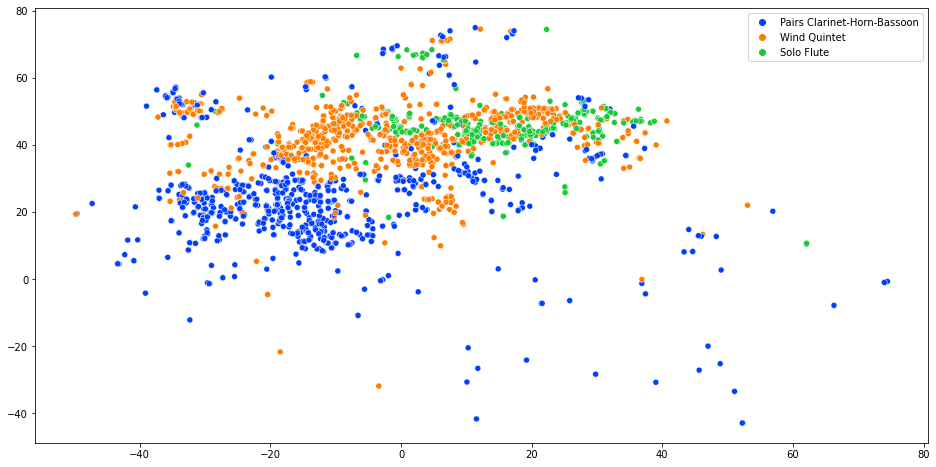

In [ ]:
#@markdown Interestingly, the model also tends to cluster together all the wind instruments, suggesting that it does not also gets individual instruments appart, but maybe even whole categories.

selectedEnsembles = ['Solo Flute', 'Wind Quintet', 'Pairs Clarinet-Horn-Bassoon']
filteredLabelsPlot = np.array(labelsPlotEnsemble)[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0]]
filteredcFeaturesTsne = cFeaturesTsne[np.where(np.isin(labelsPlotEnsemble, selectedEnsembles))[0], :]

plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=len(np.unique(labelsPlotEnsemble)))
sns.scatterplot(filteredcFeaturesTsne[:,0], filteredcFeaturesTsne[:,1], hue=filteredLabelsPlot, legend='full', 
                palette=sns.color_palette("bright", len(selectedEnsembles)))
plt.show()

### Telling apart notes

To assess with more precision the response of the model to particular notes we synthesized pure notes in the whole range present in the dataset using several of the present instruments. We use the [PrettyMIDI](https://github.com/craffel/pretty-midi) package for such end. 

One sample consisted of 1.28 seconds of a pure played by a particular instrument. We considered notes in the interval A1 to A8 (8 octaves, 84 notes), for acoustic grand piano, harpsichord, violin, viola, cello, contrabass, clarinet, bassoon, french Horn and flute, for a total of 840 audio samples, which after having passed through our CPC encoder and the average pooling layer resulted each in 16 context vectors, for a total of 13440 samples.

For instrument: Violin, note: C5


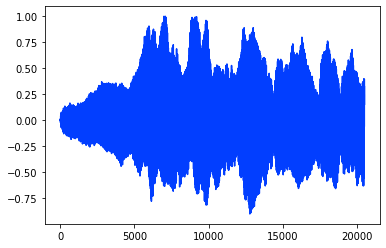

In [ ]:
#@markdown Running this cell you will get one random sample as the ones we used as input for our model in this experiment. Bear in mind that some instruments are not able to play notes in the whole range, and therefore you might get pure noise in some cases. You can re-run the cell if that happens.

instruments = ['Acoustic Grand Piano', 'Harpsichord', 'Violin', 'Viola', 'Cello', 'Contrabass', 
               'Clarinet', 'Bassoon', 'French Horn', 'Flute']
notes = range(21, 105)

def generateSample(instrument, note):
    program = pretty_midi.instrument_name_to_program(instrument)
    instrument = pretty_midi.Instrument(program=program)
    chord = pretty_midi.PrettyMIDI()
    note = pretty_midi.Note(velocity=100, pitch=note, start=0, end=20480 / 16000)
    instrument.notes.append(note)
    chord.instruments.append(instrument)
    waveForm = chord.fluidsynth(16000, "/usr/share/sounds/sf2/FluidR3_GM.sf2")
    return waveForm[:20480].astype(np.float32)

instrument = np.random.choice(instruments)
note = np.random.choice(notes)
wave = generateSample(instrument, note)
normalizer = float(np.iinfo(np.int16).max)
waveFormInt = np.array(np.asarray(wave[:20480]) * normalizer, dtype=np.int16)
wavfile.write(f'note_demo.wav', 16000, waveFormInt)
print(f"For instrument: {instrument}, note: {pretty_midi.note_number_to_name(note)}")
plt.plot(wave)
ipd.Audio('note_demo.wav')

Below we show the obtained plots for this synthetic data set.

In [ ]:
#@markdown We first realized that there were 16 well defined clusters corresponding to each of the 16 context vectors per audio sample. From this we conclude that the model considers of importance the order of events in time, and is able to track the progress of an event (a keystroke in this case).

with open(f'cVectors_pure.pickle', 'rb') as handle:
    cFeatures, instrumentLabels, notesLabels = pickle.load(handle)

cFeatures = np.vstack(cFeatures)
cFeatures = cFeatures.reshape(-1, 512)
instrumentLabels = np.repeat(instrumentLabels, 16)
notesLabels = np.repeat(notesLabels, 16)

windowLabels = []
for i in range(len(notesLabels)):
    windowLabels.append(i % 16)

with open(f'tsne2d_pure.pickle', 'rb') as handle:
    cFeaturesTsne = pickle.load(handle)

plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=len(instruments))
sns.scatterplot(cFeaturesTsne[:,0], cFeaturesTsne[:,1], hue=windowLabels, legend='full', palette=sns.color_palette("bright", len(np.unique(windowLabels))))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


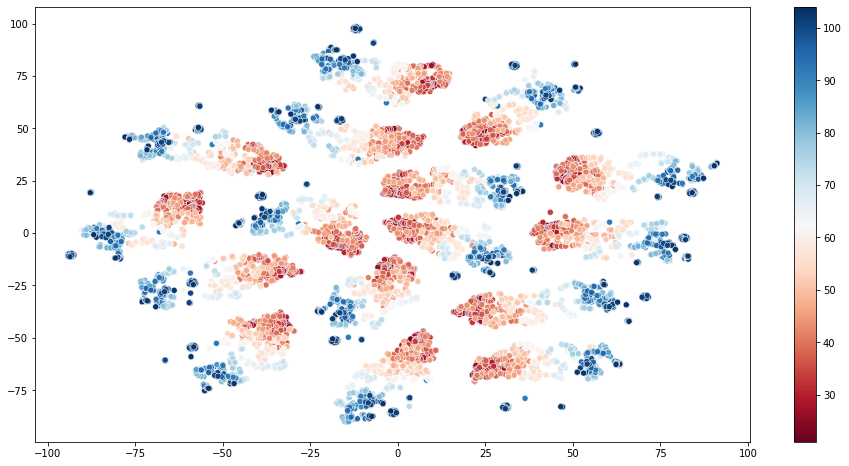

In [ ]:
#@markdown This plot shows the results of coloring the samples according to the note being played. The colorbar on the right shows the range of notes from A1 (21, lowest pitch) to A8 (105, highest pitch). Within each cluster per time window we can clearly differentiate the pitch of the different notes.

plt.figure(figsize=(16, 8))
sns.set_palette("RdBu", n_colors=len(notes))
ax = sns.scatterplot(cFeaturesTsne[:,0], cFeaturesTsne[:,1], hue=notesLabels, legend='full', palette=sns.color_palette("RdBu", len(notes)))
norm = plt.Normalize(np.min(notesLabels), np.max(notesLabels))
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm)

# Conclusions

Regarding CPC:

* Applying CPC to music results in useful encodings that contain information regarding the tones played, the instruments used, and the order of events, all of which can be used for multiple downstream tasks.

* Applying CPC as a pre-training method in MusicNet results in considerably faster convergence.

* A model using a CPC encoder will get higher performance in MusicNet with less labeled than a fully supervised one.

* The strategy for negative sampling did not seem to have an observable effect in performance for the considered downstream tasks. 

* The features extracted by CPC do not make the problem of instrument classification linearly separable.

Implementation-wise:

* Recurrent neural nets are hard to train. Transformers were an improvement in every sense.

* Adding a SincNet layer seems to be highly beneficial when dealing with audio signals.

* The transcription task was challenging to state as a generic classification task. A better formulation would likely be using a generative model.

* Building data pipelines was one of the most tedious, bug-prone, and time consuming parts of our project.

What could go next?:

* Can CPC learn to extract features with large time dependencies such as the style of a composer? We could try stacking CPC encoders.

* Stating the transcript task as a generative model problem could enable us also to "compose" music. Might be worth trying.